In [2]:
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from utils import (coupling_coef_corrs,
                   selection_profiles_by_chance,
                   get_dataset,
                   create_graph)

from pyuoi.utils import log_likelihood_glm
from pyuoi.utils import BIC
%matplotlib inline

In [3]:
fits_path = '/Users/psachdeva/fits/uoineuro/nhp/nhp_M1_indy_20160407_02.h5'

In [4]:
fits = h5py.File(fits_path, 'r')

In [5]:
uoi_poisson_coefs = fits['UoI_Poisson_log/coupling_coefs'][:]
uoi_poisson_intercepts = fits['UoI_Poisson_log/intercepts'][:]
glmnet_coefs = fits['glmnet/coupling_coefs'][:].T
n_targets = uoi_poisson_coefs.shape[1]

# Compare glmnet to UoI Poisson

## Selection Ratio

In [13]:
# selection ratio
uoi_poisson_sr = get_dataset(
    fits_path=fits_path,
    metric='selection_ratio',
    key='UoI_Poisson_log'
)

In [17]:
glmnet_sr = np.median(np.count_nonzero(glmnet_coefs, axis=2) / n_targets, axis=0)

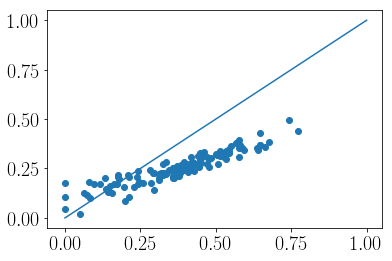

In [19]:
plt.scatter(
    glmnet_sr,
    uoi_poisson_sr
)
plt.plot([0, 1], [0, 1])

## Log likelihood

In [49]:
fits['UoI_Poisson_log/test_folds/fold_%s' %fold]

<HDF5 dataset "fold_9": shape (327,), type "<i8">

In [84]:
ll_uoi = np.zeros((10, n_targets))
ll_glmnet = np.zeros((10, n_targets))
Y = fits['UoI_Poisson_log/Y'][:]

for fold in range(10):
    print(fold)
    train_idx = fits['UoI_Poisson_log/training_folds/fold_%s' %fold][:]
    test_idx = fits['UoI_Poisson_log/test_folds/fold_%s' %fold][:]
    Y_train = Y[train_idx, :]
    Y_test = Y[test_idx, :]

    for neuron in range(n_targets):
        X_train = np.delete(Y_train, neuron, axis=1)
        X_test = np.delete(Y_test, neuron, axis=1)
        y_train = Y_train[:, neuron]
        y_test = Y_test[:, neuron]
        
        y_pred = np.exp(uoi_poisson_intercepts[fold, neuron] + np.dot(X_test, uoi_poisson_coefs[fold, neuron]))
        ll_uoi[fold, neuron] = log_likelihood_glm('poisson', y_test, y_pred)
        
        mu = np.exp(np.dot(X_train, glmnet_coefs[fold, neuron]))
        glmnet_intercept = np.log(y_train.mean() / mu.mean())
        y_pred = np.exp(glmnet_intercept + np.dot(X_test, glmnet_coefs[fold, neuron]))
        ll_glmnet[fold, neuron] = log_likelihood_glm('poisson', y_test, y_pred)

0
1
2
3
4
5
6
7
8
9


(array([ 0.,  0.,  1.,  1.,  2.,  7., 28., 44., 34., 15.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.]),
 array([-4.        , -3.57894737, -3.15789474, -2.73684211, -2.31578947,
        -1.89473684, -1.47368421, -1.05263158, -0.63157895, -0.21052632,
         0.21052632,  0.63157895,  1.05263158,  1.47368421,  1.89473684,
         2.31578947,  2.73684211,  3.15789474,  3.57894737,  4.        ]),
 <a list of 19 Patch objects>)

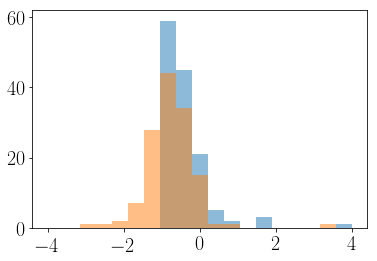

In [65]:
plt.hist(np.mean(ll_glmnet, axis=0), alpha=0.5, bins=np.linspace(-4, 4, 20))
plt.hist(np.mean(ll_uoi, axis=0), alpha=0.5, bins=np.linspace(-4, 4, 20))

# Compare UoI Poisson / UoI Lasso

In [6]:
corrs = coupling_coef_corrs(
    fits_path=fits_path,
    dataset1='UoI_Poisson_log',
    dataset2='UoI_Lasso_r2')

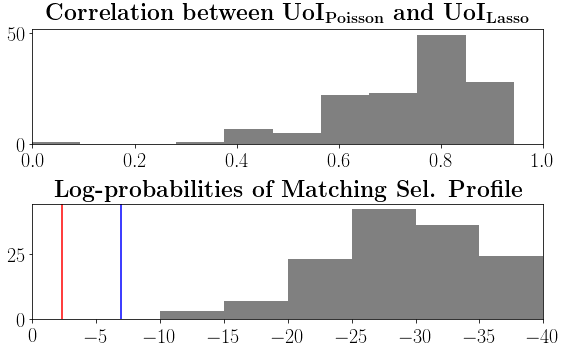

In [196]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
axes[0].hist(corrs, color='gray')
axes[0].set_xlim([0, 1])
axes[0].set_title(r'\textbf{Correlation between UoI}$_{\textbf{Poisson}}$\textbf{ and UoI}$_{\textbf{Lasso}}$', fontsize=23)

probs1[probs1 == 0] = 1e-16
axes[1].hist(np.log(probs1), color='gray', bins=np.arange(-40, 0, 5))
axes[1].axvline(np.log(0.1), color='r')
axes[1].axvline(np.log(0.001), color='b')
axes[1].set_xlim([0, -40])
axes[1].set_title(r'\textbf{Log-probabilities of Matching Sel. Profile}', fontsize=23)
plt.tight_layout()
plt.savefig('poisson_graph_comp.pdf', bbox_inches='tight')

In [18]:
probs1 = selection_profiles_by_chance(
    fits_path=fits_path,
    dataset1='UoI_Poisson_log',
    dataset2='UoI_Lasso_r2'
)

probs2 = selection_profiles_by_chance(
    fits_path=fits_path,
    dataset1='UoI_Lasso_r2',
    dataset2='UoI_Poisson_log'
)

In [27]:
G_uoi_poisson = create_graph(fits_path, dataset='UoI_Poisson_log', directed=True)
G_uoi_lasso = create_graph(fits_path, dataset='UoI_Lasso_r2', directed=True)
G_lasso = create_graph(fits_path, dataset='Lasso', directed=True)

In [121]:
Gs = [G_uoi_poisson, G_uoi_lasso, G_lasso]
closeness = [np.array(list(nx.algorithms.centrality.closeness_centrality(G).values())) for G in Gs]
eigenvec = [np.array(list(nx.algorithms.centrality.eigenvector_centrality_numpy(G).values())) for G in Gs]
betweenness = [np.array(list(nx.algorithms.centrality.betweenness_centrality(G).values())) for G in Gs]
katz = [np.array(list(nx.algorithms.centrality.katz_centrality_numpy(G, alpha=0.02).values())) for G in Gs]
indeg = [np.array(list(dict(G.in_degree()).values())) for G in Gs]
outdeg = [np.array(list(dict(G.out_degree()).values())) for G in Gs]
measures = [closeness, betweenness, indeg, eigenvec, katz, outdeg]

In [153]:
from scipy.stats import mannwhitneyu

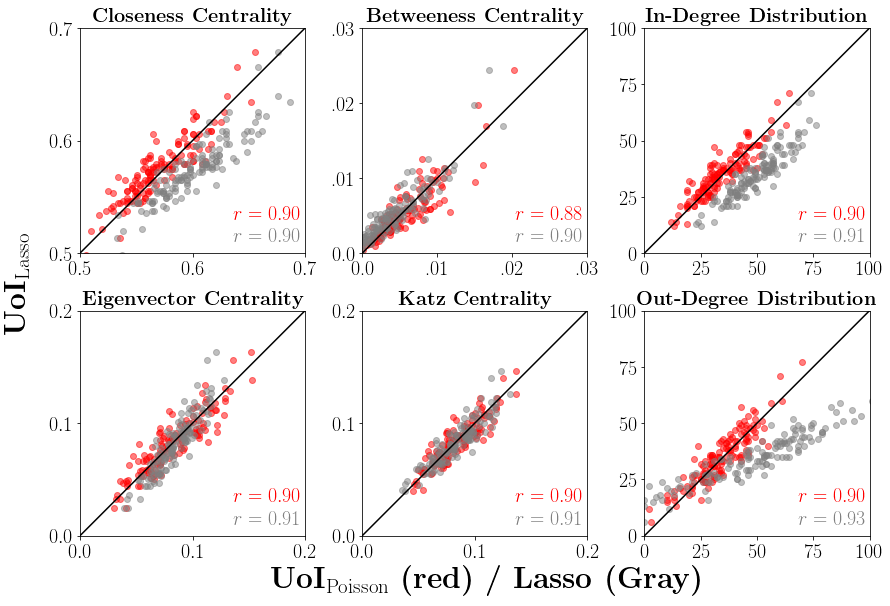

In [197]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].scatter(closeness[0], closeness[1], color='r', alpha=0.5)
axes[0, 0].scatter(closeness[2], closeness[1], color='gray', alpha=0.5)
axes[0, 0].plot([0.5, 0.7], [0.5, 0.70], color='k')
axes[0, 0].set_xlim([0.5, 0.7])
axes[0, 0].set_ylim([0.5, 0.7])
axes[0, 0].set_xticks([0.5, 0.6, 0.7])
axes[0, 0].set_yticks([0.5, 0.6, 0.7])
axes[0, 0].set_title(r'\textbf{Closeness Centrality}', fontsize=20)


axes[1, 0].scatter(eigenvec[0], eigenvec[1], color='r', alpha=0.5)
axes[1, 0].scatter(eigenvec[2], eigenvec[1], color='gray', alpha=0.5)
axes[1, 0].plot([0, 0.2], [0, 0.2], color='k')
axes[1, 0].set_xlim([0, 0.2])
axes[1, 0].set_ylim([0, 0.2])
axes[1, 0].set_xticks([0, 0.1, 0.2])
axes[1, 0].set_yticks([0, 0.1, 0.2])
axes[1, 0].set_title(r'\textbf{Eigenvector Centrality}', fontsize=20)


axes[0, 1].scatter(betweenness[0], betweenness[1], color='r', alpha=0.5)
axes[0, 1].scatter(betweenness[2], betweenness[1], color='gray', alpha=0.5)
axes[0, 1].plot([0, 0.03], [0, 0.03], color='k')
axes[0, 1].set_xlim([0, 0.03])
axes[0, 1].set_ylim([0, 0.03])
axes[0, 1].set_xticks([0, 0.01, 0.02, 0.03])
axes[0, 1].set_yticks([0, 0.01, 0.02, 0.03])
axes[0, 1].set_xticklabels(['0.0', '.01', '.02', '.03'])
axes[0, 1].set_yticklabels(['0.0', '.01', '.02', '.03'])
axes[0, 1].set_title(r'\textbf{Betweeness Centrality}', fontsize=20)


axes[1, 1].scatter(katz[0], katz[1], color='r', alpha=0.5)
axes[1, 1].scatter(katz[2], katz[1], color='gray', alpha=0.5)
axes[1, 1].plot([0, 0.2], [0, 0.2], color='k')
axes[1, 1].set_xlim([0, 0.2])
axes[1, 1].set_ylim([0, 0.2])
axes[1, 1].set_xticks([0, 0.1, 0.2])
axes[1, 1].set_yticks([0, 0.1, 0.2])
axes[1, 1].set_title(r'\textbf{Katz Centrality}', fontsize=20)


axes[0, 2].scatter(indeg[0], indeg[1], color='r', alpha=0.5)
axes[0, 2].scatter(indeg[2], indeg[1], color='gray', alpha=0.5)
axes[0, 2].plot([0, 100], [0, 100], color='k')
axes[0, 2].set_xlim([0, 100])
axes[0, 2].set_ylim([0, 100])
axes[0, 2].set_xticks([0, 25, 50, 75, 100])
axes[0, 2].set_yticks([0, 25, 50, 75, 100])
axes[0, 2].set_title(r'\textbf{In-Degree Distribution}', fontsize=20)

axes[1, 2].scatter(outdeg[0], outdeg[1], color='r', alpha=0.5)
axes[1, 2].scatter(outdeg[2], outdeg[1], color='gray', alpha=0.5)
axes[1, 2].plot([0, 100], [0, 100], color='k')
axes[1, 2].set_xlim([0, 100])
axes[1, 2].set_ylim([0, 100])
axes[1, 2].set_xticks([0, 25, 50, 75, 100])
axes[1, 2].set_yticks([0, 25, 50, 75, 100])
axes[1, 2].set_title(r'\textbf{Out-Degree Distribution}', fontsize=20)

for idx, ax in enumerate(axes.ravel()):
    ax.set_aspect('equal')
    corr1 = np.corrcoef(measures[idx][0], measures[idx][1])[0, 1]
    corr2 = np.corrcoef(measures[idx][1], measures[idx][2])[0, 1]
    fig.text(x=0.68, y=0.15, s=r'$r=%0.2f$' %corr1, color='red', transform=ax.transAxes, fontsize=20)
    fig.text(x=0.68, y=0.05, s=r'$r=%0.2f$' %corr2, color='gray', transform=ax.transAxes, fontsize=20)
    
plt.tight_layout()
fig.text(
    x=0.52, y=-0.02, s=r'\textbf{UoI}$_{\text{Poisson}}$\textbf{ (red) / Lasso (Gray)}', fontsize=30,
    horizontalalignment='center', verticalalignment='center')

fig.text(
    x=-0.02, y=0.5, s=r'\textbf{UoI}$_{\text{Lasso}}$', fontsize=30,
    horizontalalignment='center', verticalalignment='center', rotation=90
)

plt.savefig('graph_metrics.pdf', bbox_inches='tight')